In [ ]:
!pip install tensorboardx
!mkdir checkpoints
!mkdir results


mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘results’: File exists


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler
from itertools import cycle
from tensorboardX import SummaryWriter
import torch.autograd as autograd
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:

class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, dataset, n_classes, n_samples,custom_classes =None):
        loader = DataLoader(dataset)
        self.labels_list = []
        self.custom_classes = custom_classes
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}

        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            if self.custom_classes!=None:
                classes = self.custom_classes
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [ ]:


writer = SummaryWriter('runs_gan/wgangp_mnist')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


img_size = 28
##Simulataneous training of different classes
n_classes = 1
#custom_classes = np.random.randint(0,10,n_classes)
custom_classes = np.array([9])
#custom_classes = None
class_batch = 64
transform = transforms.Compose([torchvision.transforms.Resize(img_size),torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root="./", train=True,download=True,transform=transform)
#balanced_batch_sampler = BalancedBatchSampler(dataset, n_classes, class_batch,custom_classes)
batch_size = 64

#dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=balanced_batch_sampler)
class_dataset = torch.utils.data.dataset.Subset(dataset, np.where(dataset.targets==9)[0])
dataloader = torch.utils.data.DataLoader(class_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
##parameters

dim = 64
LAMBDA = 10
epochs= 2000
n_z = 128
k = 10

In [ ]:


class netD(nn.Module):
    def __init__(self):
        super(netD,self).__init__()
        self.conv1 = nn.Conv2d(1,dim,5,stride=2,padding=2)
        self.act1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(dim,dim*2,5,stride=2,padding=2)
        self.act2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(dim*2,dim*4,5,stride=2,padding=2)
        self.act3 = nn.ReLU(True)
        self.fc1 = nn.Linear(4*4*4*dim,1)

    def forward(self,input):
        input = input.view(-1,1,28,28)

        l1_1 = self.conv1(input)
        l1_2 = self.act1(l1_1)
        l2_1 = self.conv2(l1_2)
        l2_2 = self.act2(l2_1)
        l3_1 = self.conv3(l2_2)
        l3_2 = self.act3(l3_1)

        l4_1 = self.fc1(l3_2.view(-1,4*4*4*dim))
        return l4_1.view(-1)


class netG(nn.Module):
    def __init__(self):
        super(netG,self).__init__()
        self.convt1 = nn.Linear(128,4*4*4*dim)
        self.act1 = nn.ReLU(True)
        self.convt2 = nn.ConvTranspose2d(4*dim,dim*2,5)
        self.act2 = nn.ReLU(True)
        self.convt3 = nn.ConvTranspose2d(dim*2,dim,5)
        self.act3 = nn.ReLU(True)
        self.convt4 = nn.ConvTranspose2d(dim,1,8,stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self,input):
        #input = input.view(-1,1,28,28)
        l1_1 = self.convt1(input)
        l1_2 = self.act1(l1_1)
        l1_2 = l1_2.view(-1,4*dim,4,4)
        l2_1 = self.convt2(l1_2)
        l2_2 = self.act2(l2_1)
        l2_2 = l2_2[:,:,:7,:7]
        l3_1 = self.convt3(l2_2)
        l3_2 = self.act3(l3_1)
        l4_1 = self.convt4(l3_2)
        output = self.sigmoid(l4_1)
        return output.view(-1,img_size*img_size)


In [ ]:

fixed_batch = torch.rand(class_batch,128,device=device,requires_grad=False)

def calc_gradient_penalty(netD, real_data, fake_data):
    #print real_data.size()
    alpha = torch.rand(class_batch, 1).to(device)
    alpha = alpha.expand(real_data.size())
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty
#criterion = nn.BCEWithLogitsLoss()
#metanet = netD().to(device)
#tasknet = netD().to(device)
#taskoptim = optim.Adam(tasknet.parameters(),lr=0.0001)
#metaoptim = optim.Adam(metanet.parameters(),lr=0.00001)

##training

generator = netG().to(device)
discriminator = netD().to(device)
optimizerD = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerG = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))


In [ ]:

iters=0
for epoch in range(epochs):
  data_iterator = iter(dataloader)
  index = 0
  #print("coca")
  while index+k<=dataloader.__len__():
    for p in discriminator.parameters():
      p.requires_grad=True
    for _ in range(k):
      #print("cola")
      discriminator.zero_grad()
      x_real = data_iterator.next()[0].to(device)
      x_real = x_real.view(-1,img_size*img_size)
      b_size = x_real.shape[0]
      output = discriminator(x_real).view(-1)
      D_real = output.mean()

      noise = torch.randn(b_size,n_z,device= device)
      fake_data = generator(noise)
      output = discriminator(fake_data.detach()).view(-1)
      D_fake = output.mean()
      D_loss = D_fake - D_real
      D_loss.backward()
      gradient_p = calc_gradient_penalty(discriminator,x_real.detach(),fake_data.detach())
      gradient_p.backward()
      total_D_loss = D_loss + gradient_p
      optimizerD.step()
    index = index + k
    for p in discriminator.parameters():
      p.requires_grad = False
    generator.zero_grad()
    noise = torch.randn(b_size,n_z,device=device)
    fake_data = generator(noise)
    output = discriminator(fake_data).view(-1)
    G_loss = -output.mean()
    G_loss.backward()
    optimizerG.step()
    writer.add_scalar('Discriminator_Loss', total_D_loss,iters)
    writer.add_scalar('Generator_Loss',G_loss,iters)
    if iters%100==0:
      print("Epoch : "+str(epoch)+" D_Loss: " + str(total_D_loss.item())+"  G_loss: " +str(G_loss.item()))
    if epoch%50==0:
      
      torch.save(generator.state_dict(),'./checkpoints/gan_generator_'+str(iters))
      torch.save(discriminator.state_dict(),'./checkpoints/gan_discriminator_'+str(iters))
      with torch.no_grad():
        sample_batch = generator(fixed_batch).detach().cpu()
        sample_batch = sample_batch.view(-1,1,28,28)
        grid = np.concatenate([np.concatenate([sample_batch[i * 4 + j] for j in range(3)], axis=-2) for i in range(int(class_batch/4))], axis=-1)
        sample_batch = sample_batch.view(-1,28,28)
        grid2 = np.concatenate([np.concatenate([sample_batch[i * 4 + j] for j in range(3)], axis=-2) for i in range(int(class_batch/4))], axis=-1)
        plt.imsave("./results/"+str(epoch)+"_"+str(iters)+".png",grid2)
        writer.add_image('sample_output',grid,iters)
    iters = iters+1






 






Epoch : 0 D_Loss: 6.491664886474609  G_loss: 0.7783608436584473


KeyboardInterrupt: ignored

In [ ]:
!zip -r wgan_mnist_digit9_m10_result.zip ./results/
!zip -r wgan_mnist_digit9_m10_checkpoint.zip ./checkpoints/
!zip -r wgan_mnist_digit9_m5_log.zip ./runs_gan

  adding: results/ (stored 0%)
  adding: results/0_0.png (deflated 0%)
  adding: results/550_4956.png (deflated 0%)
  adding: results/650_5850.png (deflated 0%)
  adding: results/450_4055.png (deflated 0%)
  adding: results/100_902.png (deflated 0%)
  adding: results/600_5402.png (deflated 0%)
  adding: results/150_1358.png (deflated 0%)
  adding: results/250_2258.png (deflated 0%)
  adding: results/50_455.png (deflated 0%)
  adding: results/0_1.png (deflated 0%)
  adding: results/550_4955.png (deflated 0%)
  adding: results/500_4507.png (deflated 0%)
  adding: results/50_452.png (deflated 0%)
  adding: results/50_457.png (deflated 0%)
  adding: results/300_2708.png (deflated 0%)
  adding: results/150_1352.png (deflated 0%)
  adding: results/300_2707.png (deflated 0%)
  adding: results/600_5408.png (deflated 0%)
  adding: results/400_3606.png (deflated 0%)
  adding: results/450_4053.png (deflated 0%)
  adding: results/50_453.png (deflated 0%)
  adding: results/650_5858.png (deflated 0%

In [ ]:
!rm -r ./checkpoints/*
!rm -r ./results/*
!rm -r ./runs_gan/*

In [ ]:
!mv wgan_mnist_digit9_m10_result.zip /content/drive/"My Drive"/
!mv wgan_mnist_digit9_m10_checkpoint.zip /content/drive/"My Drive"/
!mv wgan_mnist_digit9_m10_log.zip /content/drive/"My Drive"/



In [ ]:
!nvidia-smi

Sun Jun 14 00:27:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/ChunyuanLI/MNIST_Inception_Score.git

Cloning into 'MNIST_Inception_Score'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 35.76 MiB | 24.54 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [ ]:
!mv ./MNIST_Inception_Score/* ./ 

In [ ]:
res_batch = torch.rand(10000,n_z).to(device)

In [ ]:
output = generator(res_batch)

In [ ]:
output.shape

torch.Size([10000, 784])

In [ ]:
import scipy.io

In [ ]:
scipy.io.savemat('./ali_results/001.mat',{'images': output.detach().cpu().numpy()})

In [ ]:
!mnist_cnn_icp_eval.py

/bin/bash: mnist_cnn_icp_eval.py: command not found


In [ ]:
!python mnist_cnn_icp_eval.py


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/__init__.py", line 61, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow', fp, pathname, description)
  File "/usr/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcudart.so.8.0: cannot open shared object file: No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "mnist_cnn_icp_eval.py", line 10, in <module>
    import tensorflow as

In [ ]:
!pip uninstall tensorflow==1.0

Uninstalling tensorflow-gpu-1.0.0:
  Would remove:
    /usr/local/bin/tensorboard
    /usr/local/lib/python3.6/dist-packages/external/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_gpu-1.0.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-gpu-1.0.0


In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size=10000,shuffle=True,num_workers=4)
x_t,_ = iter(dataloader).next()
x_t = x_t.view(-1,784)

In [ ]:
x_t.shape

torch.Size([10000, 784])

In [ ]:
scipy.io.savemat('./ali_results/001.mat',{'images': x_t.detach().cpu().numpy()})

In [ ]:





!cp /content/drive/"My Drive"/wgan_mnist_digit9_m10_checkpoint.zip ./
!unzip ./wgan_mnist_digit9_m10_checkpoint.zip


Archive:  ./wgan_mnist_digit9_m10_checkpoint.zip
  inflating: checkpoints/gan_generator_6300  
  inflating: checkpoints/gan_generator_3154  
  inflating: checkpoints/gan_discriminator_1807  
  inflating: checkpoints/gan_discriminator_3152  
  inflating: checkpoints/gan_generator_5400  
replace checkpoints/gan_generator_0? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: checkpoints/gan_generator_0  
  inflating: checkpoints/gan_generator_5407  
  inflating: checkpoints/gan_generator_5852  
  inflating: checkpoints/gan_discriminator_1357  
  inflating: checkpoints/gan_discriminator_4053  
  inflating: checkpoints/gan_generator_4  
  inflating: checkpoints/gan_generator_5858  
  inflating: checkpoints/gan_discriminator_4051  
  inflating: checkpoints/gan_discriminator_4052  
  inflating: checkpoints/gan_generator_901  
  inflating: checkpoints/gan_discriminator_3151  
  inflating: checkpoints/gan_generator_3605  
  inflating: checkpoints/gan_discriminator_1802  
  inflating: checkpoi

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./checkpoints') if isfile(join('./checkpoints', f))]
res_batch = torch.rand(10000,n_z).to(device)
fl = []
for fn in onlyfiles:
  if 'gan_generator' in fn:
    fl.append(int(fn[14:]))
sortindex = np.sort(fl)

In [ ]:
sortindex

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,  450,  451,
        452,  453,  454,  455,  456,  457,  458,  900,  901,  902,  903,
        904,  905,  906,  907,  908, 1350, 1351, 1352, 1353, 1354, 1355,
       1356, 1357, 1358, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807,
       1808, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2700,
       2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 3150, 3151, 3152,
       3153, 3154, 3155, 3156, 3157, 3158, 3600, 3601, 3602, 3603, 3604,
       3605, 3606, 3607, 3608, 4050, 4051, 4052, 4053, 4054, 4055, 4056,
       4057, 4058, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508,
       4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 5400, 5401,
       5402, 5403, 5404, 5405, 5406, 5407, 5408, 5850, 5851, 5852, 5853,
       5854, 5855, 5856, 5857, 5858, 6300, 6301, 6302, 6303, 6304, 6305,
       6306, 6307, 6308])

In [ ]:
newind = [f for f in sortindex if f%9==0]

In [ ]:
newind

[0,
 450,
 900,
 1350,
 1800,
 2250,
 2700,
 3150,
 3600,
 4050,
 4500,
 4950,
 5400,
 5850,
 6300]

In [ ]:
for ind in newind:
  gen = './checkpoints/gan_generator_'+str(ind)
  generator.load_state_dict(torch.load(gen))
  x_t = generator(res_batch)
  scipy.io.savemat('./ali_results/'+ str(ind)+'.mat',{'images': x_t.detach().cpu().numpy()})

In [ ]:
import scipy.io
!pip install tensorflow==1.0
!git clone https://github.com/ChunyuanLI/MNIST_Inception_Score.git
!mv ./MNIST_Inception_Score/* ./

fatal: destination path 'MNIST_Inception_Score' already exists and is not an empty directory.


In [ ]:
!python mnist_cnn_icp_eval.py

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:474: FutureWarning: Passing (type, 1) or 

In [ ]:
a = np.array([1.00,1.0071,1.0030,1.0172,1.0055,1.0104,1.0111,1.0101,1.0143,1.0114,1.0162,1.0142,1.0129,1.0122,1.0154])

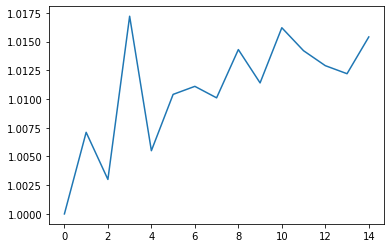

In [ ]:
plt.plot(a)